# Análise de Corvengência de Municípios
## Daniel N. Rocha, Rafael Kovashikawa, Matheus Roman e Chen Zi
### Trabalho de Estatística – FGV EPGE
O objetivo deste estudo é realizar testes estatísticos com dados empíricos do IBGE para testar a hipótese de corvergência acerca da evolução do PIB dos municípios brasileiros. Isto é, testaremos se os municípios com economia menor de fato cresceram mais rapidamente do que os que possuiam atividade econômica mais intensa.

Embora haja disponibilidade de dados a partir 1999, utilizamos o ano de 2002 como período inicial, tendo em vista que houve mudança metodológica na coleta e agregação dos dados entre os anos de 1999 e 2002. Segundo o IBGE: 

"_Para os anos anteriores a 2010, cabe ressaltar, realizou-se a retropolação dos dados até 2002, considerando-se a disponibilidade de informações para o período, e estimou-se uma nova série, adaptada às alterações da CNAE 2.0. [Classificação Nacional de Atividades Econômicas - CNAE 2.0.]_"

A série temporal termina em 2017 pois é o último ano de dados disponibilizados pelo IBGE. Dentro do recorte temporal selecionado é possível garantir que os dados são comparáveis entre si e "estão completamente integrados às séries das Contas Nacionais e das Contas Regionais do Brasil".

In [ ]:
%%capture
%pip install xlrd
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install palettable
%pip install matplotlib
%pip install jupyterthemes

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
import seaborn as sns
import palettable
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
import matplotlib.style
import matplotlib as mpl
for m,n in zip(['grid.color','axes.titlecolor','axes.labelcolor','xtick.color','ytick.color',
                'axes.titlesize','figure.figsize','legend.framealpha'],['white','white','white',
                'white','white','20.0','13.0, 8.0','0.8']):
    mpl.rcParams[m] = n

## 1. Importando os Dados:
Todos os dados foram coletados do site do IBGE e podem ser consultados no seguinte link: https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html

In [3]:
pib_cities_02_09 = pd.read_excel('PIB dos Municipios - base de dados 2002-2009.xls')
pib_cities_10_17 = pd.read_excel('PIB dos Municipios - base de dados 2010-2017.xls')

In [4]:
pib_cities = pd.concat([pib_cities_02_09, pib_cities_10_17], ignore_index=True).copy()

In [5]:
pib_cities = pib_cities[['Ano','Nome da Grande Região','Nome da Unidade da Federação','Nome do Município',
                         'Código do Município','Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)',
                         'Valor adicionado bruto total, \na preços correntes\n(R$ 1.000)',
                         'Produto Interno Bruto, \na preços correntes\n(R$ 1.000)']]
pib_cities.rename(inplace=True, columns={'Produto Interno Bruto, \na preços correntes\n(R$ 1.000)':'PIB',
                              'Valor adicionado bruto total, \na preços correntes\n(R$ 1.000)':'Valor adicionado',
                              'Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)':'PIB per capita',
                              'Nome da Grande Região':'Região','Nome da Unidade da Federação':'UF',
                              'Nome do Município':'Município'})
pib_cities

,Ano,Região,UF,Município,Código do Município,PIB per capita,Valor adicionado,PIB
0,2002,Norte,Rondônia,Alta Floresta D'Oeste,1100015,4047.83,103741.73,111290.99
1,2002,Norte,Rondônia,Ariquemes,1100023,5667.37,406926.84,449592.82
2,2002,Norte,Rondônia,Cabixi,1100031,4246.99,29899.58,31767.52
3,2002,Norte,Rondônia,Cacoal,1100049,6353.27,424820.15,474443.10
4,2002,Norte,Rondônia,Cerejeiras,1100056,4442.47,70972.64,79173.61
...,...,...,...,...,...,...,...,...
89041,2017,Centro-oeste,Goiás,Vianópolis,5222005,28942.36,367357.48,395786.81
89042,2017,Centro-oeste,Goiás,Vicentinópolis,5222054,41772.71,331192.92,350765.42
89043,2017,Centro-oeste,Goiás,Vila Boa,5222203,23992.38,112890.80,137500.32
89044,2017,Centro-oeste,Goiás,Vila Propício,5222302,32016.61,176298.36,182174.52


In [6]:
codigos_cidades = pib_cities[['Município','Código do Município']].drop_duplicates()
codigos_cidades # salvando a tabela para retirar a coluna de codigo de municipio da analise sem perdas de dados

,Município,Código do Município
0,Alta Floresta D'Oeste,1100015
1,Ariquemes,1100023
2,Cabixi,1100031
3,Cacoal,1100049
4,Cerejeiras,1100056
...,...,...
61420,Mojuí dos Campos,1504752
65699,Pescaria Brava,4212650
65801,Balneário Rincão,4220000
66119,Pinto Bandeira,4314548


In [7]:
AMCs_dict = {'Figueirão': 'Camapuã', 'Costa Rica': 'Camapuã', 'Paraíso das Águas': 'Camapuã', 'Água Clara': 'Camapuã',  # Camapuã
             'Ipiranga do Norte': 'Tapurah','Itanhangá': 'Tapurah',                                                     # Tapurah
             'Mojuí dos Campos': 'Santarém',                                                                            # Santarém
             'Aroeiras do Itaim': 'Picos',                                                                              # Picos
             'Nazária': 'Teresina',                                                                                     # Teresina
             'Pescaria Brava': 'Laguna',                                                                                # Laguna
             'Balneário Rincão': 'Içara',                                                                               # Içara
             'Pinto Bandeira': 'Bento Gonçalves'}                                                                       # Bento Gonçalves
tratamento_AMCs = pib_cities['Município'].map(AMCs_dict).fillna(pib_cities['Município'])
pib_cities['Município'] = tratamento_AMCs

In [8]:
pib_cities['População'] = pib_cities['PIB']/pib_cities['PIB per capita']
pib_cities = pib_cities.drop('Código do Município', axis=1)

In [9]:
pib_cities = pib_cities.drop('PIB per capita', axis=1)
pib_cities = pib_cities.groupby(['Ano', 'Região', 'UF', 'Município'], as_index=False).sum()
pib_cities['PIB per capita'] = pib_cities['PIB'] / pib_cities['População']
pib_cities

,Ano,Região,UF,Município,Valor adicionado,PIB,População,PIB per capita
0,2002,Centro-oeste,Distrito Federal,Brasília,46975920.59,53902199.80,2180.41,24721.18
1,2002,Centro-oeste,Goiás,Abadia de Goiás,18196.13,19813.14,5.58,3552.65
2,2002,Centro-oeste,Goiás,Abadiânia,35960.34,38866.89,12.04,3227.88
3,2002,Centro-oeste,Goiás,Acreúna,225888.33,248595.28,19.52,12736.07
4,2002,Centro-oeste,Goiás,Adelândia,7765.65,8201.22,2.50,3287.06
...,...,...,...,...,...,...,...,...
88923,2017,Sul,Santa Catarina,Zortéa,66175.80,69088.86,3.30,20936.02
88924,2017,Sul,Santa Catarina,Água Doce,277503.23,298261.42,7.15,41691.56
88925,2017,Sul,Santa Catarina,Águas Frias,83015.99,93258.91,2.39,39069.51
88926,2017,Sul,Santa Catarina,Águas Mornas,128481.50,137159.02,6.30,21778.19


### Criando colunas de variação percentual

In [10]:
pib_cities.sort_values(['Município','UF','Ano'],inplace=True,ignore_index=True)

In [11]:
pib_cities['Região']
for i in ['PIB per capita','Valor adicionado','PIB','População']:
    pib_cities['PC_'+i.split(' ')[-1]] = pib_cities.groupby(['Município','UF'])[i].apply(pd.Series.pct_change)

## 2. Plotando os Retornos:

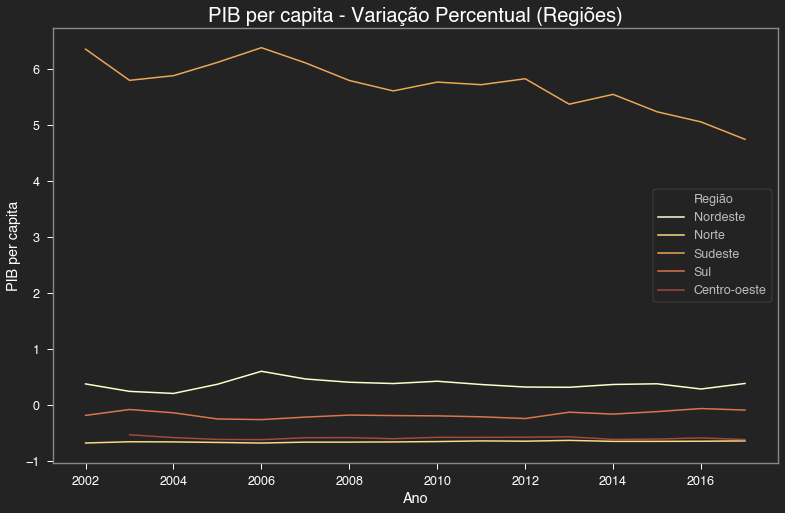

In [12]:
cmap = palettable.scientific.sequential.LaJolla_7.hex_colors[:-2]
agg=pib_cities.groupby(['Ano','Região']).sum()[['PIB per capita','Valor adicionado','PIB','População']].reset_index().copy()
data=agg[['PIB per capita','Valor adicionado','PIB','População']].pct_change().dropna().copy()
data.insert(0,'Ano',agg['Ano'])
data.insert(1,'Região',agg['Região'])
sns.lineplot(data=data,x='Ano',y='PIB per capita',hue='Região',palette=cmap)
plt.title('PIB per capita - Variação Percentual (Regiões)');

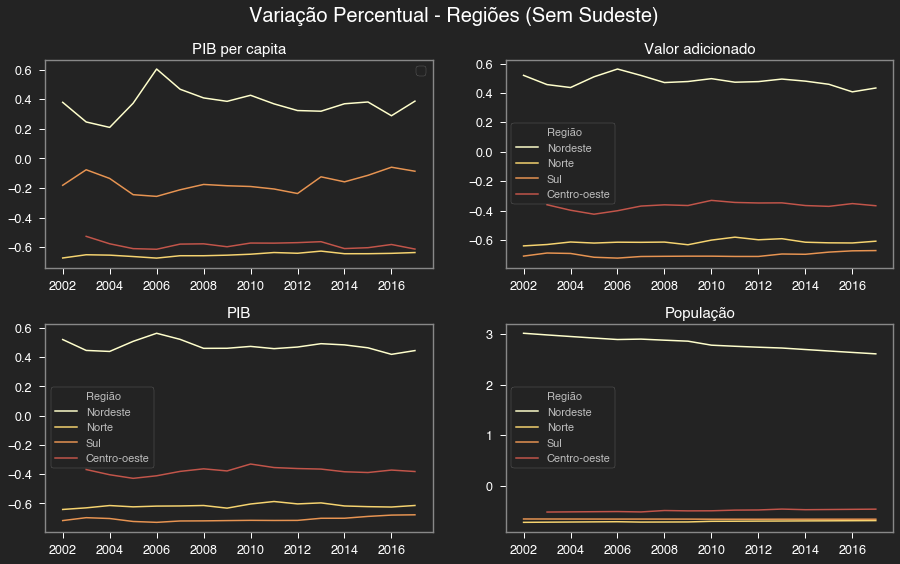

In [13]:
cmap = palettable.scientific.sequential.LaJolla_6.hex_colors[:-2]
agg=pib_cities.groupby(['Ano','Região']).sum()[['PIB per capita','Valor adicionado','PIB','População']].reset_index()
data=agg[['PIB per capita','Valor adicionado','PIB','População']].pct_change().dropna()
data.insert(0,'Ano',agg['Ano'])
data.insert(1,'Região',agg['Região'])
data = data[data['Região']!='Sudeste']
k=1
for i in ['PIB per capita','Valor adicionado','PIB','População']:
    plt.subplot(2,2,k)
    sns.lineplot(data=data,x='Ano',y=i,hue='Região',palette=cmap)
    plt.title(i,size=15)
    plt.xlabel('')
    plt.ylabel('')
    if k==1:
        plt.legend('')
    else:
        plt.legend(fontsize='small',loc='center left')
    k+=1
plt.suptitle("Variação Percentual - Regiões (Sem Sudeste)", color='w', fontsize=20)
plt.tight_layout();

In [14]:
from ordered_set import OrderedSet
init_pib = list(np.repeat(np.nan,len(OrderedSet(zip(pib_cities.UF,pib_cities.Município))))) + list(
                np.tile([pib_cities[(pib_cities.UF==k)&(pib_cities.Município==m)&
                    (pib_cities.Ano==2002)]['PIB per capita'].values[0] 
                        for k,m in OrderedSet(zip(pib_cities.UF,pib_cities.Município))],15))

In [15]:
pib_cities.sort_values(['Ano','Município','UF'],inplace=True,ignore_index=True)
pib_cities['PIB_Inicial'] = init_pib
pib_cities.sort_values(['Município','UF','Ano'],inplace=True,ignore_index=True)
pib_cities

,Ano,Região,UF,Município,Valor adicionado,PIB,População,PIB per capita,PC_capita,PC_adicionado,PC_PIB,PC_População,PIB_Inicial
0,2002,Centro-oeste,Goiás,Abadia de Goiás,18196.13,19813.14,5.58,3552.65,nan,nan,nan,nan,nan
1,2003,Centro-oeste,Goiás,Abadia de Goiás,21263.26,22773.42,5.82,3915.65,0.10,0.17,0.15,0.04,3552.65
2,2004,Centro-oeste,Goiás,Abadia de Goiás,22441.79,23756.06,6.05,3924.03,0.00,0.06,0.04,0.04,3552.65
3,2005,Centro-oeste,Goiás,Abadia de Goiás,26567.43,28156.00,6.29,4473.47,0.14,0.18,0.19,0.04,3552.65
4,2006,Centro-oeste,Goiás,Abadia de Goiás,29378.05,31164.65,6.53,4771.80,0.07,0.11,0.11,0.04,3552.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88923,2013,Sudeste,São Paulo,Óleo,60428.10,60506.29,2.68,22610.72,0.52,0.54,0.54,0.02,6787.30
88924,2014,Sudeste,São Paulo,Óleo,77075.86,77226.41,2.65,29120.06,0.29,0.28,0.28,-0.01,6787.30
88925,2015,Sudeste,São Paulo,Óleo,82658.79,83199.18,2.63,31658.75,0.09,0.07,0.08,-0.01,6787.30
88926,2016,Sudeste,São Paulo,Óleo,89060.64,89878.69,2.60,34502.38,0.09,0.08,0.08,-0.01,6787.30


In [16]:
a = 0.001 - min(pib_cities.PC_capita.dropna())
a

1.2075993985601063

In [17]:
pib_cities.PC_capita = [i+a for i in pib_cities.PC_capita]

In [22]:
pib_cities.PC_capita = np.log(pib_cities.PC_capita)
pib_cities.PIB_Inicial = np.log(pib_cities.PIB_Inicial)

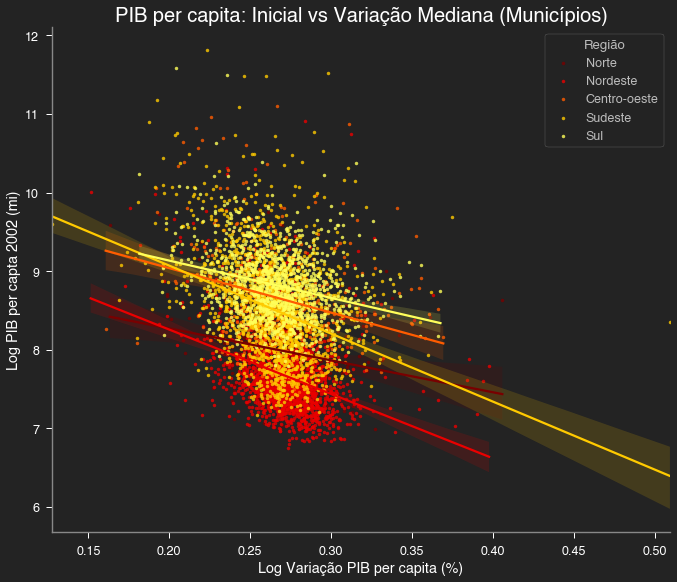

In [23]:
ax = sns.lmplot(x='PC_capita',
                y='PIB_Inicial',
                data=pib_cities.groupby(['UF','Município','Região'],as_index=False).median(),
                hue='Região',
                palette='hot',height=8,aspect=1.2,legend_out=False,scatter_kws={'s':12})
plt.ylabel('Log PIB per capta 2002 (mi)')
plt.xlabel('Log Variação PIB per capita (%)')
plt.title('PIB per capita: Inicial vs Variação Mediana (Municípios)');

## 4. Análise por Cidade:
A variação proporcional (e não absoluta) permite comparar o crescimento de cidades com economias de tamanhos distintos

In [232]:
def table_plot(restricao,show_table,show_plot):
    "Funcao auxiliar das demais funcoes abaixo. Faz ajustes na tabela e plota o grafico da cidade pedida"
    "Argumentos: restrição gerada pelas outras funções"
    city=restricao[['PIB per capita','Valor adicionado','PIB','População']].pct_change().dropna()
    city.insert(0,'Ano',restricao['Ano'])
    city.insert(1,'Região',restricao['Região'])
    city.insert(2,'UF',restricao['UF'])
    city.insert(3,'Município',restricao['Município'])
#     city.insert(4,'Município',restricao['Município'])
    if show_plot==True:
        sns.lineplot(data=city,x='Ano',y='PIB per capita',label='PIB per capita')
        sns.lineplot(data=city,x='Ano',y='Valor adicionado',label='Valor adicionado')
        sns.lineplot(data=city,x='Ano',y='PIB',label='PIB')
        sns.lineplot(data=city,x='Ano',y='População',label='População')
        plt.title(restricao['Município'].values[0]+' - Crescimento Percentual do PIB')
    if show_table == True:
        return city

def pct_change_city_name_plot(regiao,uf,municipio,show_table=False,show_plot=True):
    "Retorna os ganhos percentuais de PIB per capita, Valor Adicionado e PIB para a cidade selecionada"
    "Argumentos: macrorregiao (eg. Nordeste), unidade da federação (eg. Piauí) e municipio (eg. Teresina)"
    restricao = pib_cities[(pib_cities['Região']==regiao)&(pib_cities['UF']==uf)&(pib_cities['Município']==municipio)]
    return table_plot(restricao,show_table,show_plot)

def pct_change_city_name(nome_do_municipio,show_table=False,show_plot=True):
    "Retorna os ganhos percentuais de PIB per capita, Valor Adicionado e PIB para a cidade selecionada"
    "Argumentos: codigo da cidade do IBGE (eg. Rio de Janeiro)"
    restricao = pib_cities[pib_cities['Município']==nome_do_municipio]
    return table_plot(restricao,show_table,show_plot)

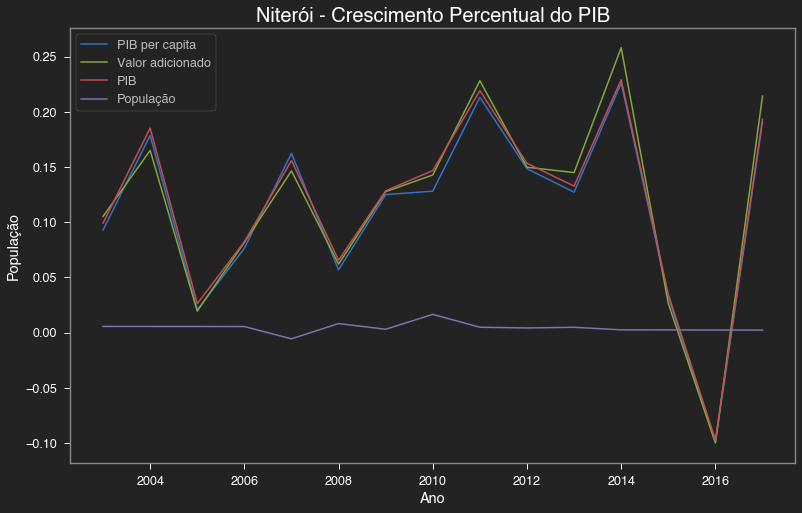

In [233]:
pct_change_city_name_plot('Sudeste', 'Rio de Janeiro', 'Niterói')

In [175]:
pct_change_city_name('Barão de Antonina',show_table=True,show_plot=False)

,Ano,Região,UF,Município,PIB per capita,Valor adicionado,PIB,População
9339,2003,Sudeste,São Paulo,Barão de Antonina,0.15,0.14,0.14,-0.01
14897,2004,Sudeste,São Paulo,Barão de Antonina,0.05,0.03,0.04,-0.01
20455,2005,Sudeste,São Paulo,Barão de Antonina,-0.09,-0.09,-0.10,-0.01
26013,2006,Sudeste,São Paulo,Barão de Antonina,0.26,0.24,0.25,-0.01
31571,2007,Sudeste,São Paulo,Barão de Antonina,-0.09,-0.04,-0.05,0.05
37129,2008,Sudeste,São Paulo,Barão de Antonina,0.12,0.14,0.15,0.03
42687,2009,Sudeste,São Paulo,Barão de Antonina,0.02,0.03,0.02,0.00
48245,2010,Sudeste,São Paulo,Barão de Antonina,0.05,0.18,0.16,0.10
53803,2011,Sudeste,São Paulo,Barão de Antonina,0.15,0.16,0.16,0.01
59361,2012,Sudeste,São Paulo,Barão de Antonina,0.12,0.12,0.13,0.01
